In [ ]:
%pylab inline

This notebook contains code to reproduce the following from Mitra, et al.:

* Extended Data Fig. 5: TR mutation burden near SNPs associated with ASD and related traits

In [19]:
# Make editable in Illustrator
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Imports
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats
import statsmodels.api as sm

# Plot colors
AFF_COLOR = "red"
UNAFF_COLOR = "blue"

# Output path info
OUTDIR = "pdfs/"

### GWAS SNPs Input Files
ASDFN = "/storage/ileena/denovos5/ASD_GWAS_iPSYC_PGC/ALL_ASD_GWAS_50000.bed"
SCZFN = "/storage/ileena/denovos5/SCZ_GWAS/SCZ_50000.bed"
EAFN = "/storage/ileena/denovos5/SCZ_GWAS/EA_50000.bed"

# Input per-locus info
LOCFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.locus_stats.tab"

# Input mutation results
MUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_GW_priors_Jan20/combined/SSC_allphases_011720_denovos_GW_priors_Jan20.final_qc_mutations.tab"
NAIVEMUTFILE = "/storage/ileena/ssc-gangstr-denovos/denovos_naive_Jan20/SSC_allphases_011720_denovos_naive_Jan20.final_qc_mutations.tab"

# Load expansions
ndata = pd.read_csv(NAIVEMUTFILE, sep="\t")
ndata = ndata[(ndata["posterior"]==-1) & (ndata["mutsize"]>=5)] # moderately big expansion events

# Filter ones that occur too many times
expcounts = ndata.groupby(["chrom","pos"], as_index=False).agg({"child": len})
ndata = pd.merge(ndata, expcounts[expcounts["child"]<=3][["chrom","pos"]], on=["chrom","pos"])

# Load main mutations data
alldata = pd.read_csv(MUTFILE, sep="\t")
usefams = set(alldata["family"])

# Concatenate expansions
ndata = ndata[ndata.family.isin(usefams)]
alldata = pd.concat([alldata, ndata])

# Manually remove problematic families. TODO add this instead to the QC script
# 14151 proband had 130 mutations
# other families have <20 in both proband and sibling
rmfams = [14151, 12434, 12281, 13673, 13351, 13355, 13143]
alldata = alldata[~alldata.family.isin(rmfams)]

# # Load annotation info
ANNOTFILE = "/storage/mgymrek/ssc-denovos/annotations/hg38_gangstr_MasterAnnotation-rmdup.bed"
annot = pd.read_csv(ANNOTFILE, sep="\t")

# Set up fields
def GetChrom(x):
    if "chr" in str(x): return int(x[3:])
    else: return int(x)
alldata["chrom"] = alldata["chrom"].apply(GetChrom)
annot = annot[annot["chrom"].apply(lambda x: x not in ["X","chrX","Y","chrY"])]
annot["chrom"] = annot["chrom"].apply(GetChrom)
annot["pos"] = annot["start"]

# Merge
adata = pd.merge(alldata, annot, on=["chrom","pos"])

# Get age info
AGEFILE = "/storage/ileena/denovos4/metadata/ssc_4phases_ages.csv"
ages = pd.read_csv(AGEFILE)
ages["family"] = ages["fam_id"]
ages["child"] = ages["sample_id"]
ages["phenotype"] = ages["ssc_id"].apply(lambda x: [1,2]["p1" in x])
ages = ages[~np.isnan(ages["father_age_birth"])]

# Get Allele freq info
HETFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_het.tab"
het = pd.read_csv(HETFILE, sep="\t")
het["chrom"] = het["chrom"].apply(GetChrom)

AFREQFILE = "/storage/mgymrek/ssc-denovos/allele-freqs/SSC_merged_allele_counts.tab"
afreq = pd.read_csv(AFREQFILE, sep="\t")
afreq.columns = ["chrom","pos","newallele","count"]
afreq["chrom"] = afreq["chrom"].apply(GetChrom)
afreq = pd.merge(afreq, het[["chrom","pos","total"]], on=["chrom","pos"])
afreq["freq"] = afreq.apply(lambda x: float(x["count"])/x["total"], 1)

fdata = pd.merge(adata, afreq, on=["chrom","pos","newallele"], how="left")

fdata.ix[np.isnan(fdata["freq"]),"freq"] = 0
fdata.ix[np.isnan(fdata["count"]),"count"] = 0

fdata = pd.merge(fdata, het[["chrom","pos","het"]], on=["chrom","pos"])
finaldata = pd.merge(fdata, ages[["family","child","sex","father_age_birth_years"]], on=["family","child"], how="left")
finaldata.chrom = finaldata.chrom.astype(int)
finaldata.pos = finaldata.pos.astype(int)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:93: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:94: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated


In [29]:
# PLOT function

def GetCounts(df, pt, families, sex=None):
    famcounts = {}
    counts = df[df["phenotype"]==pt]
    if sex is not None:
        counts = counts[counts["sex"]==sex]
    for i in range(counts.shape[0]):
        fam = counts["family"].values[i]
        count = counts["nummut"].values[i]
        famcounts[fam] = count
    mutcounts = [famcounts.get(family, 0) for family in families]
    return mutcounts

def PlotBurden(full_fdata, fdata_list, fdata_list_labels, col=None, freq=1, figprefix=None, adjust_patage=False):
    fdata = full_fdata
    
    # Get list of families to use
    families = set(fdata["family"])
    aff_female_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="female")]["family"])
    unaff_female_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="female")]["family"])
    aff_male_families = set(fdata[(fdata["phenotype"]==2) & (fdata["sex"]=="male")]["family"])
    unaff_male_families = set(fdata[(fdata["phenotype"]==1) & (fdata["sex"]=="male")]["family"])

    pt_counts_list_unaff = []
    pt_stderrs_list_unaff = []
    pt_counts_list_aff = []
    pt_stderrs_list_aff = []
    male_counts_list_unaff = []
    male_counts_list_aff = []
    female_counts_list_unaff = []
    female_counts_list_aff = []

    perc_mut_aff_all_list = []
    perc_mut_aff_female_list = []
    perc_mut_aff_male_list = []
    total_mut_all_list = []
    total_mut_female_list = []
    total_mut_male_list = []
    
    sizes_means_list_unaff = []
    sizes_stderrs_list_unaff = []
    sizes_means_list_aff = []
    sizes_stderrs_list_aff = []
    female_sizes_means_list_unaff = []
    female_sizes_means_list_aff = []
    male_sizes_means_list_unaff = []
    male_sizes_means_list_aff = []
    
    for i in range(len(fdata_list)):
        fdata = fdata_list[i]
        flabel = fdata_list_labels[i]
        usedata = fdata[(fdata["freq"]<=freq)]
        if col is not None:
            usedata = usedata[(usedata[col]>0)]
        print("Number of TR mutations analyzed: N=%s"%usedata.shape[0])
        child_counts = usedata.groupby(["child","phenotype","family","father_age_birth_years"], as_index=False).agg({"posterior": len})
        child_counts.columns = ["child","phenotype","family","father_age_birth_years","nummut"]
        child_counts_by_sex = usedata.groupby(["child","phenotype","family","sex"], as_index=False).agg({"posterior": len})
        child_counts_by_sex.columns = ["child","phenotype","family","sex","nummut"]

        aff_counts = GetCounts(child_counts, 2, families)
        unaff_counts = GetCounts(child_counts, 1, families)
        aff_male_counts = GetCounts(child_counts_by_sex, 2, aff_male_families, sex="male")
        aff_female_counts = GetCounts(child_counts_by_sex, 2, aff_female_families, sex="female")
        unaff_male_counts = GetCounts(child_counts_by_sex, 1, unaff_male_families, sex="male")
        unaff_female_counts = GetCounts(child_counts_by_sex, 1, unaff_female_families, sex="female")
    
        pt_counts = np.array([np.mean(unaff_counts), np.mean(aff_counts)])
        pt_stderrs = np.array([np.sqrt(np.var(unaff_counts)/len(families)), np.sqrt(np.var(aff_counts)/len(families))])
    
        # Update data lists
        pt_counts_list_unaff.append(np.mean(unaff_counts))
        pt_counts_list_aff.append(np.mean(aff_counts))
        pt_stderrs_list_unaff.append(np.sqrt(np.var(unaff_counts)/len(families)))
        pt_stderrs_list_aff.append(np.sqrt(np.var(aff_counts)/len(families)))
        male_counts_list_unaff.append(np.mean(unaff_male_counts))
        male_counts_list_aff.append(np.mean(aff_male_counts))
        female_counts_list_unaff.append(np.mean(unaff_female_counts))
        female_counts_list_aff.append(np.mean(aff_female_counts))
        
        # P-values
        print("***Test burden - %s"%flabel)
        print(len(unaff_counts))
        print("Unaff mean=%s"%np.mean(unaff_counts))
        print("Aff mean=%s"%np.mean(aff_counts))
        try:
            print(scipy.stats.mannwhitneyu(unaff_counts, aff_counts,  alternative="less"))
        except: pass
        try:
            print("Male burden: %s"%str(scipy.stats.mannwhitneyu(unaff_male_counts, aff_male_counts,  alternative="less")))
        except: pass
        try:
            print("Female burden: %s"%str(scipy.stats.mannwhitneyu(unaff_female_counts, aff_female_counts,  alternative="less")))
        except: pass
        # odds ratios
        print("***Odds ratios")
        or_all = np.mean(aff_counts)/np.mean(unaff_counts)
        or_male = np.mean(aff_male_counts)/np.mean(unaff_male_counts)
        or_female = np.mean(aff_female_counts)/np.mean(unaff_female_counts)
        print("all=%s"%or_all)
        print("num proband all=%s"%len(aff_counts))
        print("num unaff all=%s"%len(unaff_counts))
         
        total_mut_all_list.append(np.sum(aff_counts)+np.sum(unaff_counts))
        perc_mut_aff_all_list.append(np.sum(aff_counts)/(np.sum(aff_counts)+np.sum(unaff_counts)))
        total_mut_female_list.append(np.sum(aff_female_counts)+np.sum(unaff_female_counts))
        perc_mut_aff_female_list.append(np.sum(aff_female_counts)/(np.sum(aff_female_counts)+np.sum(unaff_female_counts)))
        total_mut_male_list.append(np.sum(aff_male_counts)+np.sum(unaff_male_counts))
        perc_mut_aff_male_list.append(np.sum(aff_male_counts)/(np.sum(aff_male_counts)+np.sum(unaff_male_counts)))
    
        
        ### Compute genome-wide p-value, adjusting for age of father ###
        if adjust_patage:
            unaff_counts = child_counts[child_counts["phenotype"]==1]
            X = sm.add_constant(np.array(unaff_counts[["father_age_birth_years"]]))
            Y = np.array(unaff_counts["nummut"])
            model = sm.OLS(Y, X).fit()

            # Predict and get residuals for all
            child_counts["pred_nummut"] = model.predict(sm.add_constant(np.array(child_counts[["father_age_birth_years"]])))
            child_counts["resid_nummut"] = child_counts["nummut"]-child_counts["pred_nummut"]

            # Compute p-val
            print("***Test burden - adjust for age of father")
            print(scipy.stats.mannwhitneyu(child_counts[child_counts["phenotype"]==1]["resid_nummut"],
                            child_counts[child_counts["phenotype"]==2]["resid_nummut"],  alternative="less"))
  
    ########### Main bar plot showing diff ############
    fig = plt.figure()
    fig.set_size_inches((5+len(fdata_list), 5))
    ax = fig.add_subplot(111)
    
    # Plot overall
    W = 0.2
    xvals = range(len(fdata_list))
    ax.bar(xvals, pt_counts_list_unaff, yerr=1.96*np.array(pt_stderrs_list_unaff), color=UNAFF_COLOR, width=W)
    ax.bar([item+W for item in xvals], pt_counts_list_aff, yerr=1.96*np.array(pt_stderrs_list_aff), color=AFF_COLOR, width=W)

    # Plot by sex
    ptsize = 100
    ax.scatter([item-W for item in xvals], male_counts_list_unaff, marker="s", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item-W for item in xvals], female_counts_list_unaff, marker="o", color=UNAFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], male_counts_list_aff, marker="s", color=AFF_COLOR, s=ptsize, edgecolors="black")
    ax.scatter([item+2*W for item in xvals], female_counts_list_aff, marker="o", color=AFF_COLOR, s=ptsize, edgecolors="black")

    # Hide the right and top spines
    ax.set_xticks([item+W/2 for item in xvals])
    ax.set_xticklabels(fdata_list_labels, rotation=90)
    ax.set_ylabel("# mutations/child", size=15)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom');
    
    ax.set_title(col)
    if figprefix is not None:
        fig.savefig(os.path.join(OUTDIR, figprefix+"-burden.pdf"))
          

In [45]:
# PLOT
traitsdict = {"ASD":ASDFN,
              "SCZ":SCZFN,
              "EA":EAFN}
traitsdf_all = {}
traitsdf_common = {}

for trait in traitsdict.keys():
    print("TRAIT:", trait)
    gwas = pd.read_csv(traitsdict[trait], sep="\s+", header=None, names=["snp_chr", "snp_pos", "chrom", "pos", "bp_overlap"])
    # merge TR mutations and SNP windows
    gwas = gwas[gwas.chrom != "X"]
    gwas.chrom = gwas.chrom.astype(int)
    gwas.pos = gwas.pos.astype(int)
    finalgwasdata = pd.merge(finaldata.copy(), gwas, how="left", on=["chrom","pos"])
    traitsdf_all[trait] = finalgwasdata[~np.isnan(finalgwasdata.snp_pos)].copy()
    traitsdf_common[trait] = finalgwasdata[(finalgwasdata.freq>0.05) & (~np.isnan(finalgwasdata.snp_pos))].copy()


TRAIT: ASD
4213
TRAIT: SCZ
22811
TRAIT: EA
25668


Number of TR mutations analyzed: N=4213
***Test burden - ASD_all
1593
Unaff mean=1.305084745762712
Aff mean=1.3396107972379159
MannwhitneyuResult(statistic=1253057.5, pvalue=0.2612892022341798)
Male burden: MannwhitneyuResult(statistic=529411.5, pvalue=0.4144856242236079)
Female burden: MannwhitneyuResult(statistic=81538.5, pvalue=0.5113959296999794)
***Odds ratios
all=1.0264550264550263
num proband all=1593
num unaff all=1593
Number of TR mutations analyzed: N=22811
***Test burden - SCZ_all
1593
Unaff mean=7.008788449466415
Aff mean=7.3107344632768365
MannwhitneyuResult(statistic=1219152.0, pvalue=0.02755322523702097)
Male burden: MannwhitneyuResult(statistic=510562.5, pvalue=0.058099492943362606)
Female burden: MannwhitneyuResult(statistic=82349.5, pvalue=0.5966967234784554)
***Odds ratios
all=1.0430810568741604
num proband all=1593
num unaff all=1593
Number of TR mutations analyzed: N=25668
***Test burden - EA_all
1593
Unaff mean=7.894538606403013
Aff mean=8.218455743879472
Mannwhit

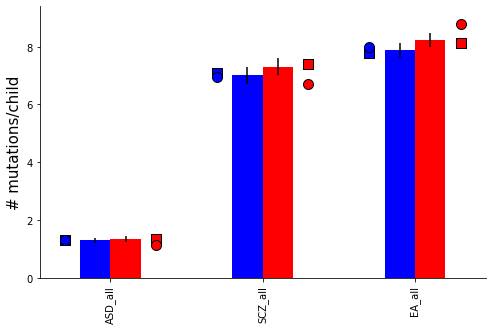

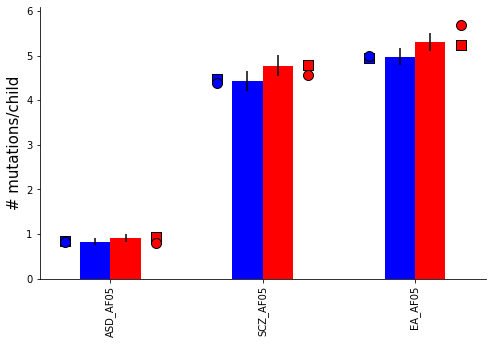

In [54]:
# Plot all mutations
PlotBurden(finalgwasdata, [traitsdf_all[x] for x in traitsdf_all.keys()], [x+"_all" for x in traitsdf_all.keys()]) 

# Ploat TR mutations w/ AF >5%
PlotBurden(finalgwasdata, [traitsdf_common[x] for x in traitsdf_common.keys()], [x+"_AF05" for x in traitsdf_common.keys()]) 
